This notebook will explore some options available when building a Long Short-Term Memory (LSTM) TensorFlow model.

I will use a toy dataset from IMDb movie reviews for sentiment analysis.<br>
The LSTM models will be built for binary classification of the reviews.

It should be noted that in order to lighten the computation time, these models will not be cross validated.<br>
Normally, this should be done to ensure the results are accurate and reproducible.<br>
Instead, I will set all random seeds and GPU settings to ensure this analysis will be deterministic.<br>
This will enable me to focus on the model and data structures, as well as the hyperparameters.

 > **MODULE IMPORTS**

In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import numpy as np
import time
import pandas as pd
import os

In [3]:
# import TF tools
from tensorflow.config.experimental import (
    list_physical_devices, set_memory_growth, list_logical_devices)
from tensorflow import get_logger
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback, TensorBoard, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [4]:
# import seed generators
from random import seed as rn_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed

 > **DETERMINISTIC SETTINGS**

In [5]:
# choose integer to set all random seeds
GLOBAL_SEED = 27

In [6]:
def set_seeds(seed=GLOBAL_SEED):
    """Set random seed and deterministic GPU settings"""
    # set random seed for Python environment
    os.environ['PYTHONHASHSEED'] = str(seed)
    # set random seed for random module
    rn_seed(seed)
    # set random seed for Keras stochastic events
    np_seed(seed)
    # set random seed for Tensorflow stochastic events
    set_seed(seed)
    # set CuDNN to be deterministic
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

 > **GPU SPECIFICATIONS**

I will restrict GPU memory to grow as needed.

In [7]:
# get list of all physical GPUs
gpus = list_physical_devices('GPU')
# allow slow growth of GPU memory, as needed
if gpus:
    try:
        # enable memory growth for all GPUs
        for gpu in gpus:
            set_memory_growth(gpu, True)
        # get number of logical GPUs
        logical_gpus = list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", 
              len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


 > **PLOTTING SPECIFICATIONS**

In [8]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "my_big_pallette.colors(<index>)" as color attribute for Seaborn plots.
Use "my_big_pallette.my_pallete[<slice>]" as palette attribute for Seaborn plots.
This is your color palette...


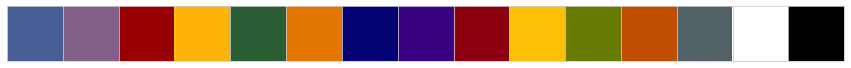

In [9]:
# import custom palette
import my_big_palette as mp

 > **WARNING SETTINGS**

In [10]:
# remove deprecation warning
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
get_logger().setLevel('ERROR')

 > **DATA WRANGLING**

Now, I will grab the toy IMDb dataset, provided by the Keras library.

In [11]:
# import dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=GLOBAL_SEED)

In [12]:
# observe the first 10 encodings of first review and its label
X_train[0][:10], y_train[0]

([1, 6341, 9, 31, 7, 61, 32, 58, 1640, 248], 1)

This data has been preprocessed.<br>
This notebook will not be focused on transforming raw data to use in Tensorflow.<br>
That work will be demonstrated in other nortebooks in this and other repositories.<br>
I will mainly be exploring the model architecture, after optimizing the dataset.

In [13]:
# observe size of datasets
len(X_train), len(X_test)

(25000, 25000)

Strangely, the data is evenly split between training and test sets.<br>
I will redistribute the observations to be of the customary 80:20 split.

In [14]:
def resplit_data(X_train, y_train, X_test, y_test):
    """Return redistributed dataset as 80:20 split"""
    
    # get lengths of given datasets
    n_train, n_test = len(X_train), len(X_test)
    # get total number of reviews
    n_reviews = n_train + n_test
    
    # calculate number of reviews for training dataset
    n_train_new = int(n_reviews * 0.8)
    # calculate number of reviews to transfer from test dataset
    n_reviews_to_shift = n_train_new - n_train
    
    # redistribute reviews
    X_train = np.concatenate((X_train, X_test[:n_reviews_to_shift]))
    y_train = np.concatenate((y_train, y_test[:n_reviews_to_shift]))
    X_test = X_test[n_reviews_to_shift:n_test]
    y_test = y_test[n_reviews_to_shift:n_test]
    
    return X_train, y_train, X_test, y_test

In [15]:
# resplit data
X_train, y_train, X_test, y_test = resplit_data(X_train, y_train, X_test, y_test)
# observe size of new datasets
len(X_train), len(X_test)

(40000, 10000)

Now, I'd like to know the length of the largest review and the total number of words in the corpus.

In [16]:
# get number of words in longest review
longest_review_size = max(len(word) for word in X_train)
longest_review_size

2494

In [17]:
# get number of unique words over all reviews
full_corpus_size = int(max([word for review in X_train for word in review]) + 1)
full_corpus_size

88587

I would like to be able to adjust these values to optimize the models.<br>
I will build a function to do that, while padding the reviews to give them the same number of words.

In [18]:
def get_datasets(corpus_word_lim=None, review_word_lim=None):
    """Return padded training and test data with an 80:20 split and define input size"""
    
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=corpus_word_lim, 
                                                          seed=GLOBAL_SEED)
    # adjust data split to 80:20
    X_train, y_train, X_test, y_test = resplit_data(X_train, y_train, X_test, y_test)
    
    # define length of longest review, if not explicit in function call
    if not corpus_word_lim:
        corpus_word_lim = max([word for review in X_train for word in review]) + 1
        
    # pad reviews to ensure they are all the same length
    X_train = sequence.pad_sequences(X_train, maxlen=review_word_lim)
    X_test = sequence.pad_sequences(X_test, maxlen=review_word_lim)
    
    return X_train, y_train, X_test, y_test, int(corpus_word_lim)

Now, I will create my new datsets.

In [19]:
# get full datasets
X_train, y_train, X_test, y_test, input_size = get_datasets()

 > **BASE MODEL**

I will create functions to build the LSTM models, train them, store them, and return plots of their training data.

By default, the models will have only 1 LSTM layer with 128 neurons.<br>
A dropout layer can be added after each LSTM layer, if desired.<br>
The default learning rate will be 0.001, and the batch size is initially set to 32.

The training will run for 20 epochs.<br>
Early stopping will be called after 3 epochs, where the validation loss has not improved by 0.001.

In [20]:
def get_compiled_lstm(n_units=1, n_nodes=128, dropout=0, l_rate=1e-3, seed=GLOBAL_SEED):
    """Return compiled LSTM model with specified architecture"""
    
    # reset seeds for reproducibility
    set_seeds(seed)
    
    # instantiate sequential model with embedding layer
    model = Sequential()
    model.add(Embedding(input_size, n_nodes))
    # add middle memory units, if specified
    if n_units > 1:
        for unit in range(n_units - 1):
            model.add(LSTM(n_nodes, return_sequences=True))
            model.add(Dropout(dropout))
    # add final memory unit
    model.add(LSTM(n_nodes))         
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    # define loss function, optimizer, and metrics        
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=l_rate), 
                  metrics=['accuracy'])
            
    # observe architecture
    model.summary()

    return model

In [21]:
class LogEpochTimeCallback(Callback):
    """Custom callback to log wall time at end of each training epoch"""
    
    def __init__(self, start_time=0):
        super(LogEpochTimeCallback, self).__init__()
        # initialize training start time
        self.start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        # calculate elapsed time from start of training
        logs['wall_time'] = time.time() - self.start_time

In [22]:
def train_model(model, model_name, n_early_epochs=3, batch_size=32, n_epochs=20):
    """Return best trained model, test loss, and test accuracy"""
    
    # define EarlyStopping, Custom LogEpochTime, TensorBoard, and CSVLogger callbacks
    callbacks = [EarlyStopping(min_delta=0.001, patience=n_early_epochs, 
                               verbose=1, restore_best_weights=True), 
                 LogEpochTimeCallback(), 
                 TensorBoard('../tensorboard_logs/' + model_name, histogram_freq=1), 
                 CSVLogger('../training_logs/' + model_name)]
    
    # train model
    model.fit(X_train, y_train, 
              batch_size=batch_size, 
              epochs=n_epochs, 
              callbacks=callbacks, 
              verbose=1, 
              validation_data=(X_test, y_test), 
              shuffle=False)
    
    # save model to M.2
    model.save('../saved_models/' + model_name)
    # reload model with best weights
    lstm = load_model('../saved_models/' + model_name)
    
    # evaluate best model on test data
    loss, accuracy = lstm.evaluate(X_test, y_test, 
                                   batch_size=batch_size, 
                                   verbose=1)
    
    print('\nTest loss:', loss)
    print('Test accuracy:', accuracy)

In [23]:
def get_training_data(model):
    """Return dict of training data, while appending epoch data"""
    # get training history
    data = model.history.history
    # append epoch data to history
    data['epoch'] = list(range(1, len(data['loss']) + 1))
    
    print('Wall Time:', data['wall_time'][-1])

    return data

In [24]:
def plot_one_model(data_dict, x_var):
    """Plot training run for one model, allowing different features for x-axis"""

    # convert training dict to DataFrame
    data = pd.DataFrame(data_dict)
    
    # establish subplots frame
    plt.subplots(2, 1, sharex=True, figsize=(12,5))
    
    # start loss plot
    plt.subplot(2, 1, 1)
    
    # mark minimum loss epoch
    best_val_loss = data['val_loss'].min()
    best_epoch = data.loc[data['val_loss'] == data['val_loss'].min()][x_var].values[0]
    plt.scatter(best_epoch, best_val_loss, s=100, c='k', marker='*', label='Best Loss')


    # plot training and test losses
    sns.lineplot(x=data[x_var], y=data['loss'], 
                 label='Training Loss', color=mp.colors(5)).set(xlabel=None)
    sns.lineplot(x=data[x_var], y=data['val_loss'], 
                 label='Validation Loss', color=mp.colors(0)).set(xlabel=None)
    
    # plot verticle line epoch markers
    plt.xticks(data[x_var], [])
    
    plt.ylabel('Loss', fontsize=15)
    
    plt.legend()
    plt.title('Loss and Accuracy for LSTM IMDb Movie Review Prediction', fontsize=17)
    
    # start accuracy plot
    plt.subplot(2, 1, 2)
    
    # plot training and test accuracy
    sns.lineplot(x=data[x_var], y=data['accuracy'], 
                 label='Training Accuracy', color=mp.colors(5))
    sns.lineplot(x=data[x_var], y=data['val_accuracy'], 
                 label='Validation Accuracy', color=mp.colors(0))
    
    # plot integer xticks
    int_xticks = list(map(lambda x: int(np.round(x, 1)), data[x_var]))
    plt.xticks(int_xticks)
    
    plt.xlabel(x_var.capitalize().replace('_', ' '), fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    
    plt.legend()

I will begin with observing the results of running the models without word limits.<br>
I would like for each epoch to take under 2 minutes to execute, while attempting to minimize the validation loss.

I will get a base model on the full dataset with one LSTM layer and no dropout.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         11339136  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 11,470,849
Trainable params: 11,470,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 195s 156ms/step - loss: 0.4290 - accuracy: 0.8059 - val_loss: 0.4427 - val_accuracy: 0.8101 - wall_time: 196.7799
Epoch 2/20
1250/1250 [==============================] - 194s 155ms/step 

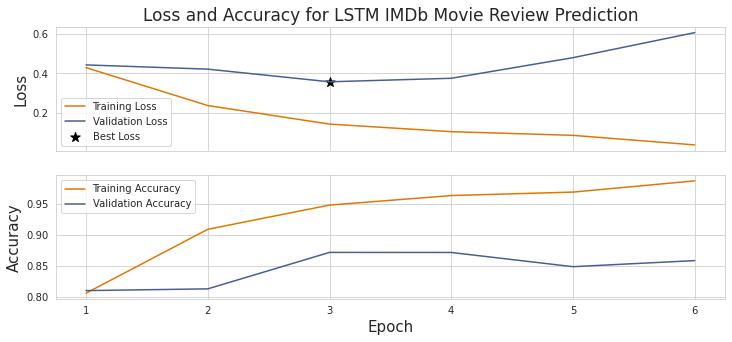

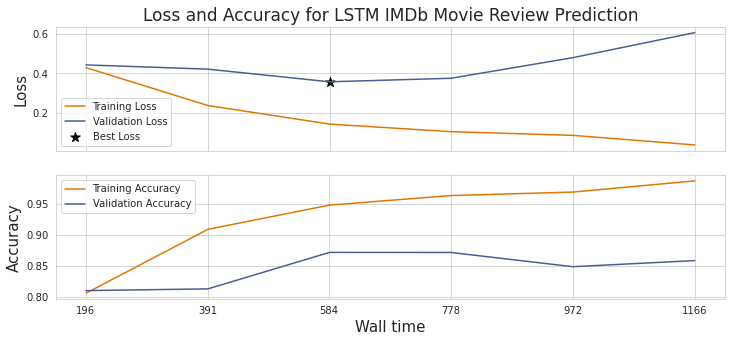

In [25]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dense layer
# corpus word limit -> 88,587 words
# review word limit -> 2494 words

# build and compile model
model_0 = get_compiled_lstm()
# train model
train_model(model_0, 'model_0')
# store training data in dict
data_0 = get_training_data(model_0)
# plot training data
plot_one_model(data_0, x_var='epoch')
plot_one_model(data_0, x_var='wall_time')

The training is a little slow.<br>
I will explore putting limits on the number of words being used to address this issue.<br>
This adjustment will be balanced with the model performance to ensure increased optimization.

 > **DATASET OPTIMIZATION**

Now, I will limit the the input vector to the top one third of the words occuring throughout the reviews.

In [26]:
# get one third the number of unique words over all reviews
corpus_size = int(full_corpus_size / 3)
corpus_size

29529

In [27]:
# get new datasets
X_train, y_train, X_test, y_test, input_size = get_datasets(corpus_word_lim = corpus_size)

Now, I will train with this limited corpus.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         3779712   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,911,425
Trainable params: 3,911,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 144s 115ms/step - loss: 0.4292 - accuracy: 0.8055 - val_loss: 0.3224 - val_accuracy: 0.8681 - wall_time: 144.8448
Epoch 2/20
1250/1250 [==============================] - 143s 114ms/step 

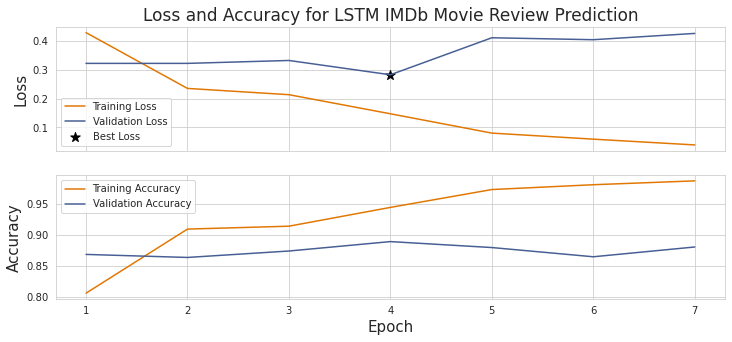

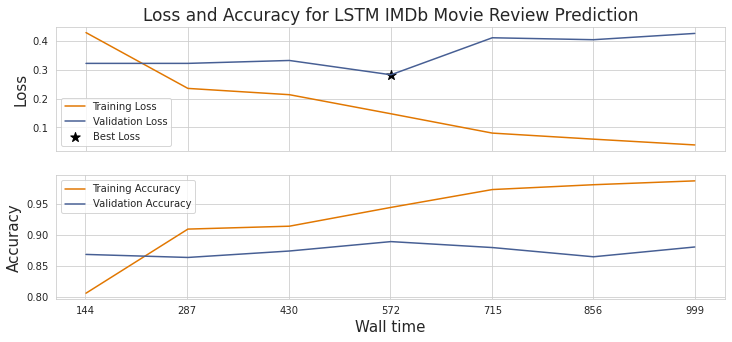

In [28]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 2494 words

# build and compile model
model_1 = get_compiled_lstm()
# train model
train_model(model_1, 'model_1')
# store training data in dict
data_1 = get_training_data(model_1)
# plot training data
plot_one_model(data_1, x_var='epoch')
plot_one_model(data_1, x_var='wall_time')

The time cost has improved a bit, and the test loss has gotten much better.

Now, I observe the results of limiting the length of the reviews to one third that of the longest review.

In [29]:
# pad all review lengths to one third the amount of words that are in the longest review
review_size = int(longest_review_size / 3)
review_size

831

In [30]:
# get new datasets
X_train, y_train, X_test, y_test, input_size = get_datasets(review_word_lim=review_size)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         11339136  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 11,470,849
Trainable params: 11,470,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 114s 91ms/step - loss: 0.4265 - accuracy: 0.8080 - val_loss: 0.3147 - val_accuracy: 0.8699 - wall_time: 114.6282
Epoch 2/20
1250/1250 [==============================] - 113s 91ms/step 

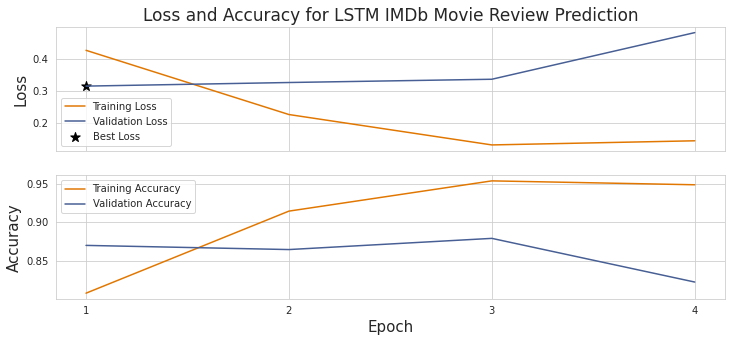

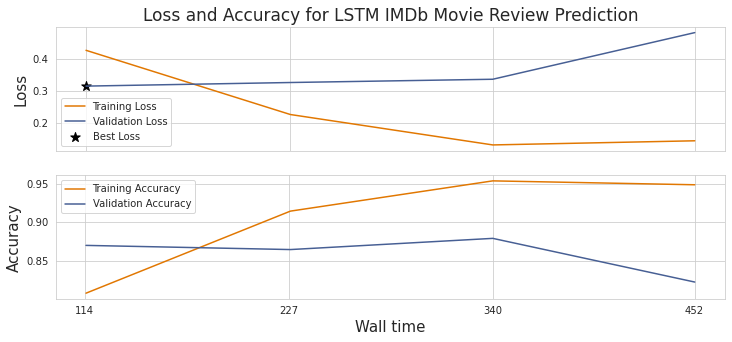

In [31]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dense layer
# corpus word limit -> 88,587 words
# review word limit -> 831 words

# build and compile model
model_2 = get_compiled_lstm()
# train model
train_model(model_2, 'model_2')
# store training data in dict
data_2 = get_training_data(model_2)
# plot training data
plot_one_model(data_2, x_var='epoch')
plot_one_model(data_2, x_var='wall_time')

The training time has improved, even more, but the test loss has show only slight improvement.

To be thorough, I will limit both the number of words in the input layer, as well as the length of the reviews.

In [32]:
# get new datasets
X_train, y_train, X_test, y_test, input_size = get_datasets(corpus_word_lim = corpus_size, 
                                                            review_word_lim=review_size)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         3779712   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,911,425
Trainable params: 3,911,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 59s 47ms/step - loss: 0.4838 - accuracy: 0.7681 - val_loss: 0.3219 - val_accuracy: 0.8659 - wall_time: 60.1917
Epoch 2/20
1250/1250 [==============================] - 59s 47ms/step - los

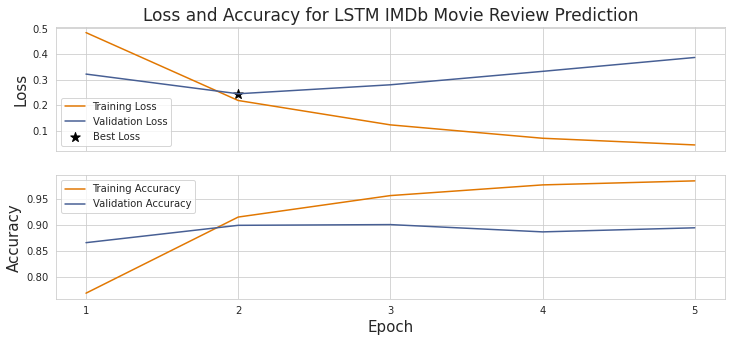

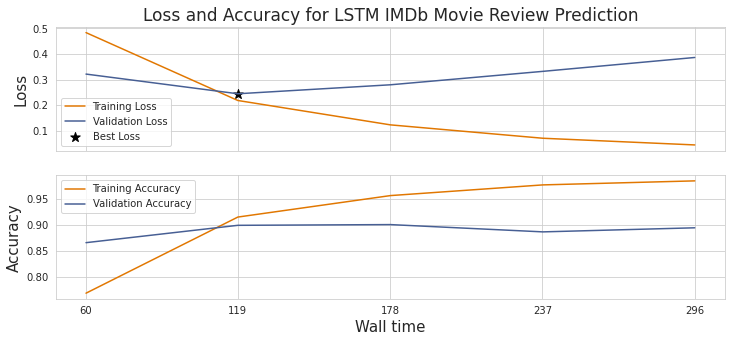

In [33]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words

# build and compile model
model_3 = get_compiled_lstm()
# train model
train_model(model_3, 'model_3')
# store training data in dict
data_3 = get_training_data(model_3)
# plot training data
plot_one_model(data_3, x_var='epoch')
plot_one_model(data_3, x_var='wall_time')

The training time has improved the most, and the test loss is the best, yet.

I will create functions to collect the training data and plot these results to compare.

In [34]:
def get_training_logs():
    """Return list of model training logs as DataFrames"""
    
    # instantiate list to hold training log DataFrames
    df_lst = []
    # get number of trained models
    num_models = len(os.listdir('../saved_models'))
    
    # loop through all models in 'saved_models' folder
    for num in range(num_models):
        # read in training log and add to list, while giving DataFrame a unique name
        df_lst.append(
            pd.read_csv(
                '../training_logs/model_' + str(num)).rename_axis('model_' + str(num)))
        # rename epochs to start at 1, instead of 0
        df_lst[num]['epoch'] = df_lst[num]['epoch'] + 1
        
    return df_lst

In [35]:
# collect all training data
df_lst = get_training_logs()
# observe first DataFrame
df_lst[0]

,epoch,accuracy,loss,val_accuracy,val_loss,wall_time
model_0,,,,,,
0,1,0.805950,0.429012,0.8101,0.442687,196.779862
1,2,0.908775,0.238653,0.8129,0.421363,390.958279
2,3,0.947750,0.145525,0.8716,0.357848,584.623759
3,4,0.963100,0.107505,0.8715,0.375529,778.068249
4,5,0.968700,0.089002,0.8486,0.478984,972.206241
5,6,0.986750,0.040935,0.8584,0.604732,1166.339761


In [36]:
def plot_training_data(model_lst, x_var):
    """Plot training run for given LSTM models, allowing different features for x-axis"""
    
    # establish subplots frame
    plt.subplots(2, 1, sharex=True, figsize=(15, 7))
    
    # set rounding accuracy for x-axis
    if x_var == 'epoch':
        decimal_round = -0
    else:
        decimal_round = -1
    # select xticks to show, based on data points
    all_ticks = list(set(
        [int(np.round(item, decimal_round)) for lst in [
            model[x_var] for model in model_lst] for item in lst]))
        
    # start loss plot
    plt.subplot(2, 1, 1)
    
    for model in model_lst:
        # mark minimum loss epoch
        best_val_loss = model['val_loss'].min()
        best_epoch = model.loc[
            model['val_loss'] == model['val_loss'].min()][x_var].values[0]
        plt.scatter(best_epoch, best_val_loss, s=50, c='k', marker='*')  
        
        # plot test loss
        sns.lineplot(x=model[x_var], y=model['val_loss'], 
                     label=model.index.name).set(xlabel=None)
            
    # plot verticle line epoch markers
    plt.xticks(all_ticks, [])

    plt.ylim(0.2, 0.5)
        
    plt.ylabel('Loss', fontsize=15)

    plt.legend(loc=4)
    plt.title('Loss and Accuracy for LSTM IMDb Movie Review Prediction', fontsize=17)

    # start accuracy plot
    plt.subplot(2, 1, 2)
    
    for model in model_lst:
        # plot test accuracy
        sns.lineplot(x=model[x_var], y=model['val_accuracy'], 
                     label=model.index.name)
        
    # plot tick labels, based on data points
    if x_var == 'epoch':
        plt.xticks(all_ticks, fontsize='large')
    else:
        plt.xticks(all_ticks, rotation=70)
        plt.tick_params(axis='x', labelsize='large')
    
    plt.ylim(0.77, 0.91)
        
    plt.xlabel(x_var.capitalize().replace('_', ' '), fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)

    plt.legend(loc=4)

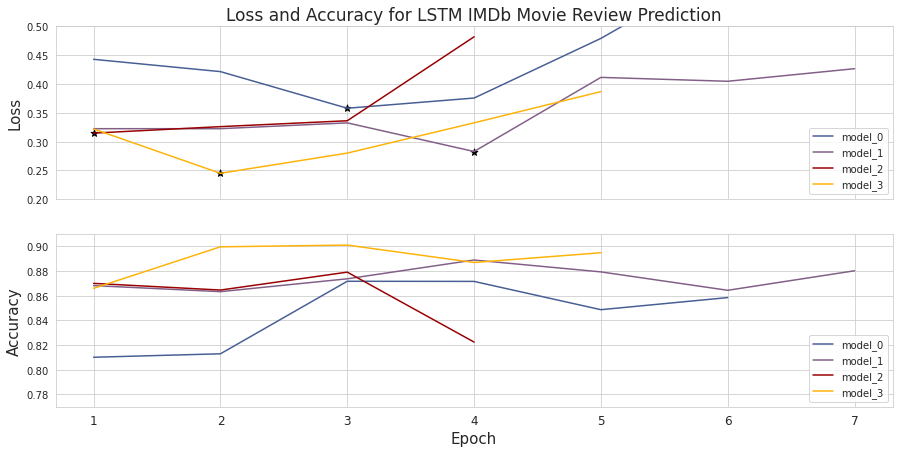

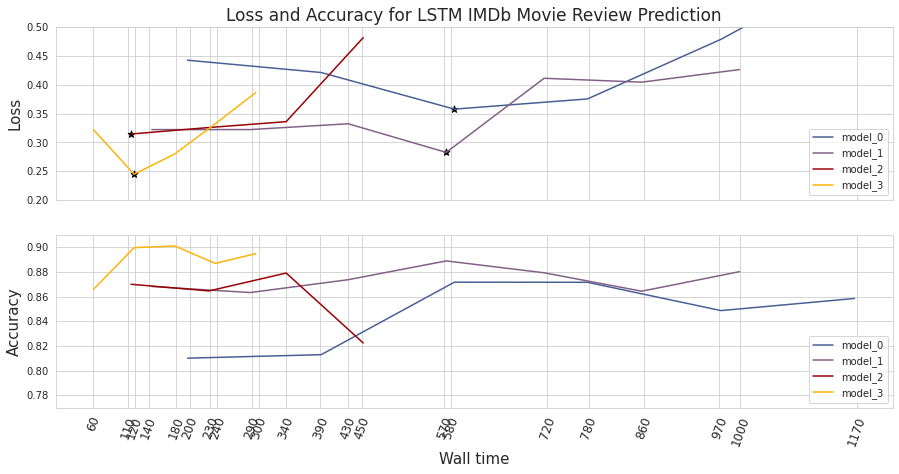

In [37]:
# create list of models to observe
training_lst = [df_lst[0], df_lst[1], df_lst[2], df_lst[3]]
# plot chosen models
plot_training_data(training_lst, x_var='epoch')
plot_training_data(training_lst, x_var='wall_time')

Each of the four models were optimized after different numbers of epochs.<br>
Models 3 (corpus word limit and review length limit) had the shortest training time and the best test loss.<br>
I will keep this version of the dataset going forward.

 > **DROPOUT RATE**

I will address any overfitting by regularization through the addition of a dropout layer.<br>
Various dropout rates will be tried, between 10% and 40%.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         3779712   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 3,911,425
Trainable params: 3,911,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 60s 48ms/step - loss: 0.4044 - accuracy: 0.8202 - val_loss: 0.3227 - val_accuracy: 0.8707 - wall_time: 60.9357
Epoch 2/20
1250/1250 [==============================] - 59s 47ms/step - los

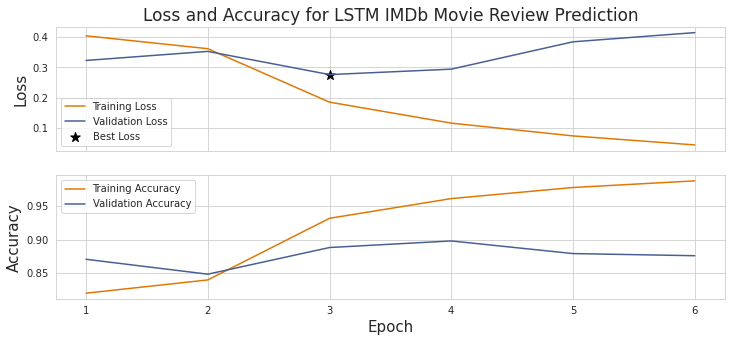

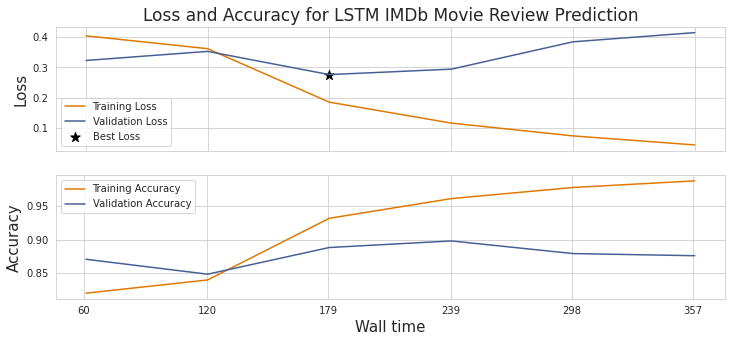

In [38]:
# model architecture: 1 Embedding -> 1 LSTM -> Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# dropout -> 0.1

# build and compile model
model_4 = get_compiled_lstm(dropout=0.1)
# train model
train_model(model_4, 'model_4')
# store training data in dict
data_4 = get_training_data(model_4)
# plot training data
plot_one_model(data_4, x_var='epoch')
plot_one_model(data_4, x_var='wall_time')

Training time is similar to model 3 (no dropout), but the test loss has not improved.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         3779712   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,911,425
Trainable params: 3,911,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 60s 48ms/step - loss: 0.4581 - accuracy: 0.7880 - val_loss: 0.3569 - val_accuracy: 0.8481 - wall_time: 60.9898
Epoch 2/20
1250/1250 [==============================] - 59s 47ms/step - los

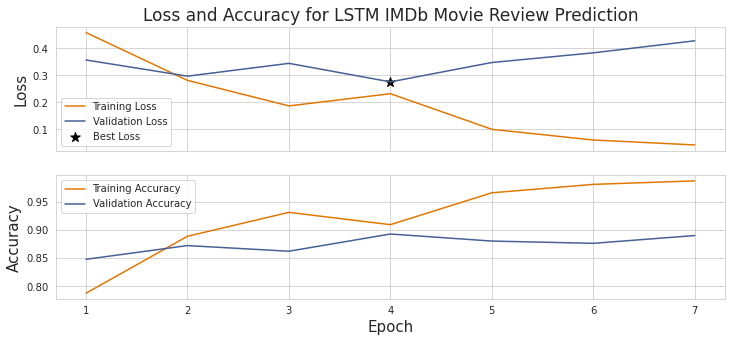

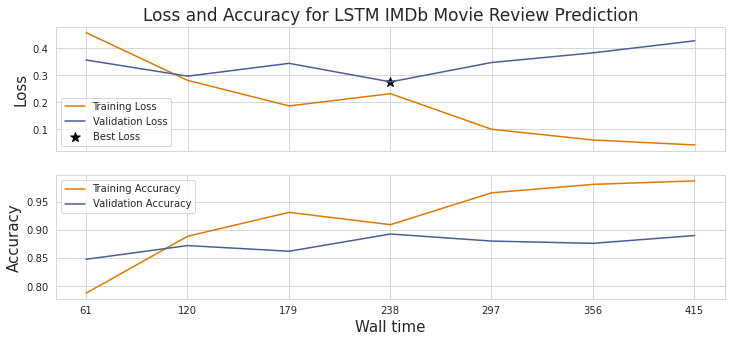

In [39]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# dropout -> 0.2

# build and compile model
model_5 = get_compiled_lstm(dropout=0.2)
# train model
train_model(model_5, 'model_5')
# store training data in dict
data_5 = get_training_data(model_5)
# plot training data
plot_one_model(data_5, x_var='epoch')
plot_one_model(data_5, x_var='wall_time')

Similarly, training time has not changed by much, and the test loss has not improved.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         3779712   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,911,425
Trainable params: 3,911,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 60s 48ms/step - loss: 0.4239 - accuracy: 0.8066 - val_loss: 0.3759 - val_accuracy: 0.8425 - wall_time: 60.7378
Epoch 2/20
1250/1250 [==============================] - 59s 48ms/step - los

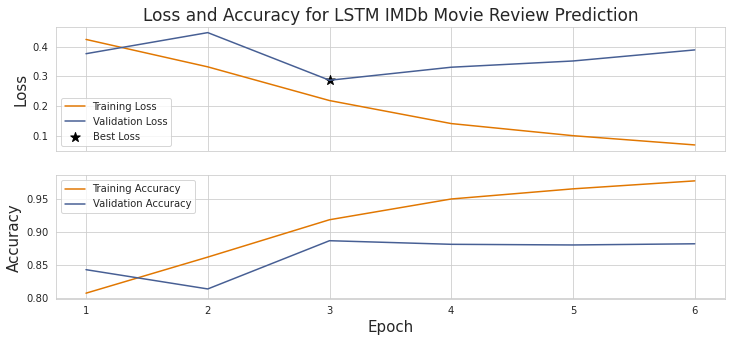

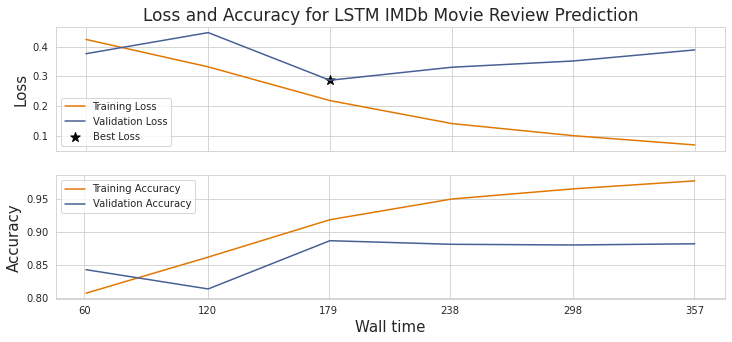

In [40]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# dropout -> 0.3

# build and compile model
model_6 = get_compiled_lstm(dropout=0.3)
# train model
train_model(model_6, 'model_6')
# store training data in dict
data_6 = get_training_data(model_6)
# plot training data
plot_one_model(data_6, x_var='epoch')
plot_one_model(data_6, x_var='wall_time')

Again, training time has not changed by much, and the test loss has not improved.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         3779712   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 3,911,425
Trainable params: 3,911,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 59s 47ms/step - loss: 0.4898 - accuracy: 0.7646 - val_loss: 0.4365 - val_accuracy: 0.8169 - wall_time: 60.4598
Epoch 2/20
1250/1250 [==============================] - 59s 47ms/step - los

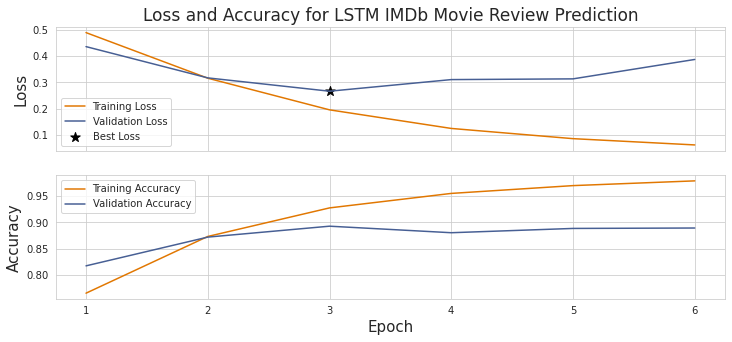

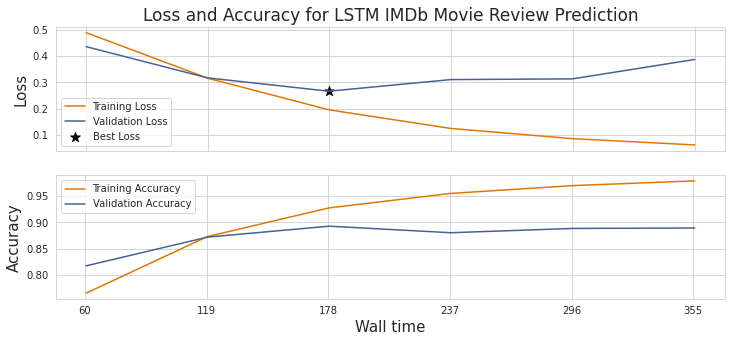

In [41]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# dropout -> 0.4

# build and compile model
model_7 = get_compiled_lstm(dropout=0.4)
# train model
train_model(model_7, 'model_7')
# store training data in dict
data_7 = get_training_data(model_7)
# plot training data
plot_one_model(data_7, x_var='epoch')
plot_one_model(data_7, x_var='wall_time')

Yet again, training time has not changed by much, and the test loss has not improved.

Now, I will plot the different dropout rates to compare.<br>
The dropout rate increases with the model number.

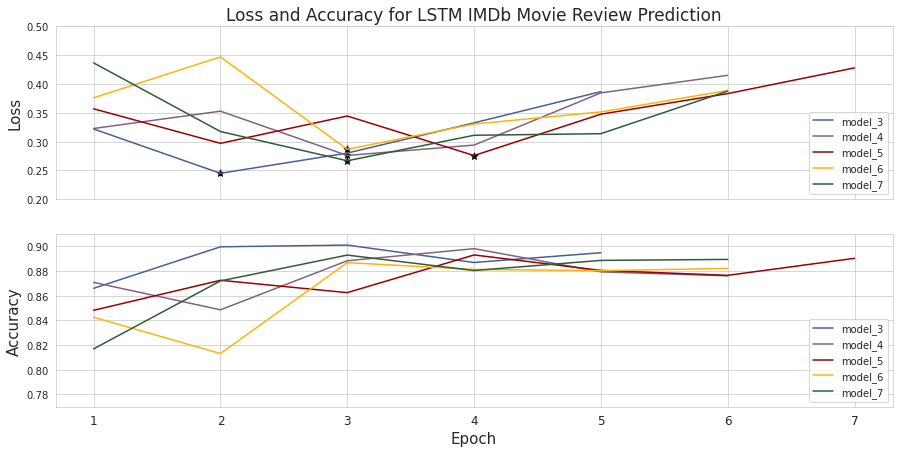

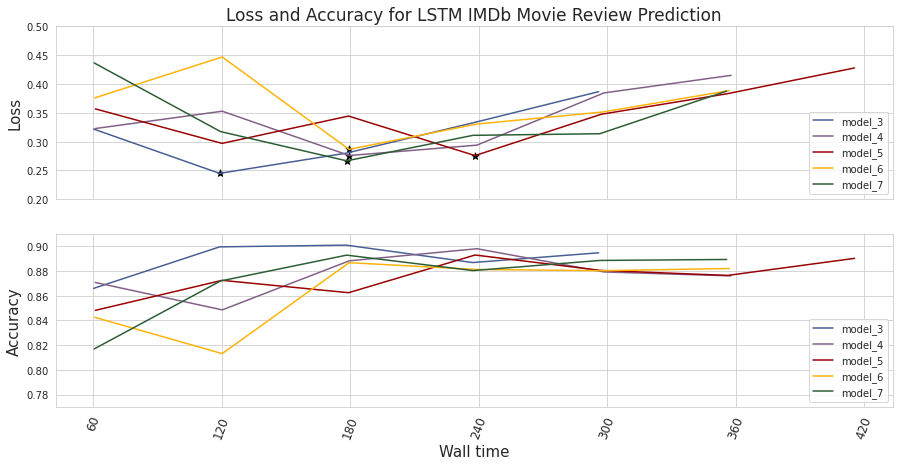

In [42]:
# collect all training data
df_lst = get_training_logs()
# create list of models to observe
training_lst = [df_lst[3], df_lst[4], df_lst[5], df_lst[6], df_lst[7]]
# plot chosen models
plot_training_data(training_lst, x_var='epoch')
plot_training_data(training_lst, x_var='wall_time')

Model 3, without a dropout layer, is still the best scoring model.<br>
I will continue without dropout layers.

 > **BATCH SIZE AND LEARNING RATE**

I will attempt to speed up the training by increasing the batch size, while increasing the learning rate, as well.<br>
I will double both values.

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         3779712   
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 3,911,425
Trainable params: 3,911,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
625/625 [==============================] - 35s 57ms/step - loss: 0.4601 - accuracy: 0.7856 - val_loss: 0.4717 - val_accuracy: 0.7761 - wall_time: 36.5924
Epoch 2/20
625/625 [==============================] - 35s 56ms/step - loss: 0

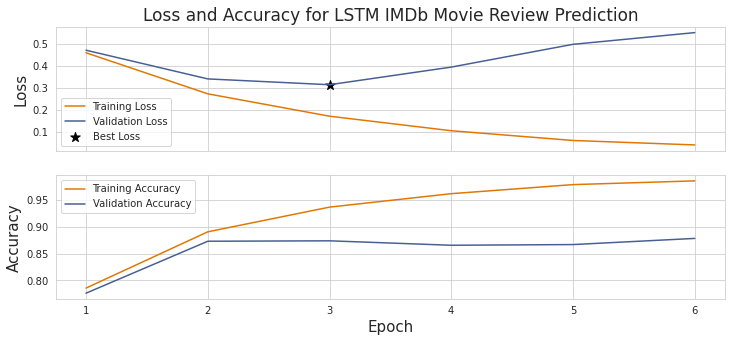

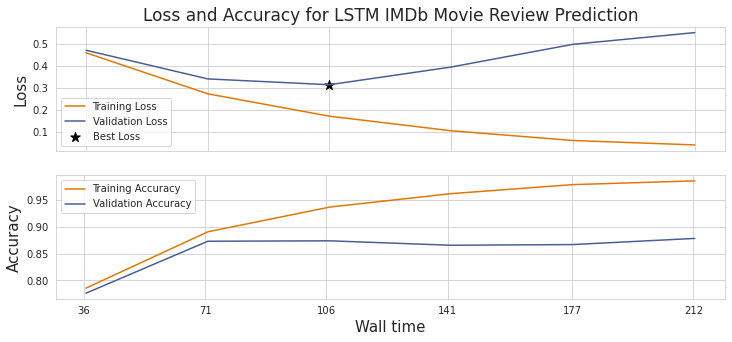

In [43]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# batch size -> 64
# learning rate -> 0.002

# build and compile model
model_8 = get_compiled_lstm(l_rate=2e-3)
# train model
train_model(model_8, 'model_8', batch_size=64)
# store training data in dict
data_8 = get_training_data(model_8)
# plot training data
plot_one_model(data_8, x_var='epoch')
plot_one_model(data_8, x_var='wall_time')

The training time has been successfully decreased.

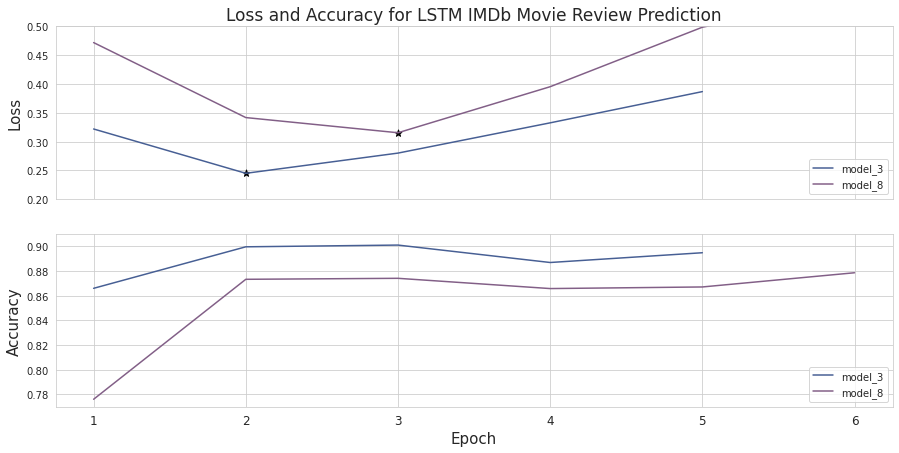

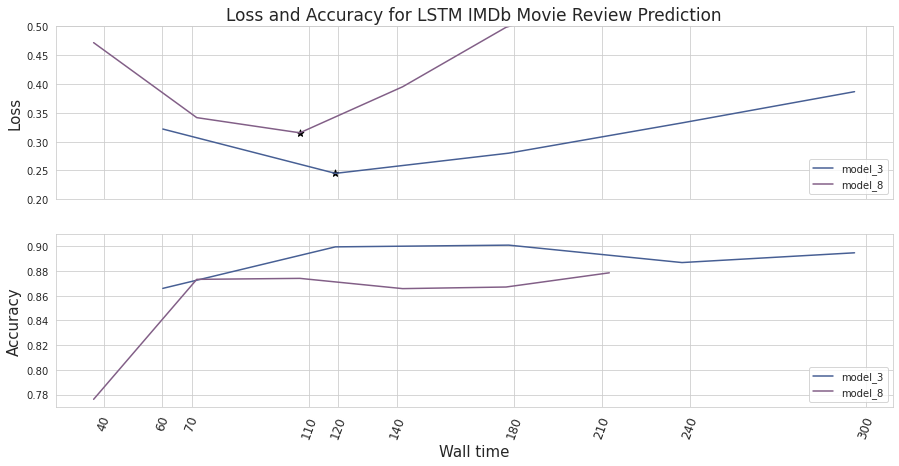

In [44]:
# collect all training data
df_lst = get_training_logs()
# create list of models to observe
training_lst = [df_lst[3], df_lst[8]]
# plot chosen models
plot_training_data(training_lst, x_var='epoch')
plot_training_data(training_lst, x_var='wall_time')

Even though model 3 finished training in fewer epochs, model 8 had a quicker wall time by 84 seconds.<br>
It found its optimal test loss only 12 seconds faster, though.

Model 3 retained its spot for lowest test loss.<br>
I will proceed without using the increased batch size and learning rate.

 > **STACKED LAYERS**

I will add more LSTM layers to the model to look for improvements.<br>
Stacked layers will be incremented up to 3 layers deep.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         3779712   
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 4,043,009
Trainable params: 4,043,009
Non-trainable params: 0
____________________________________________

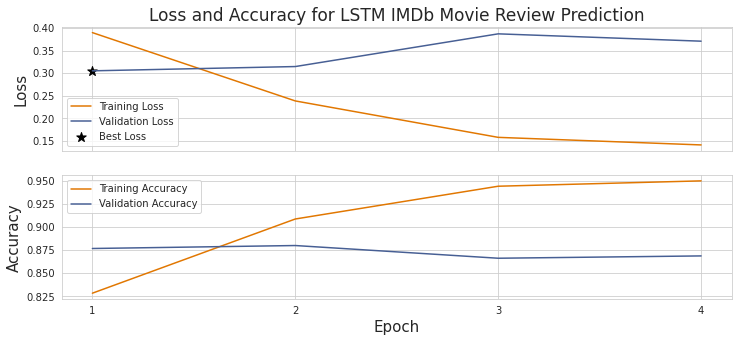

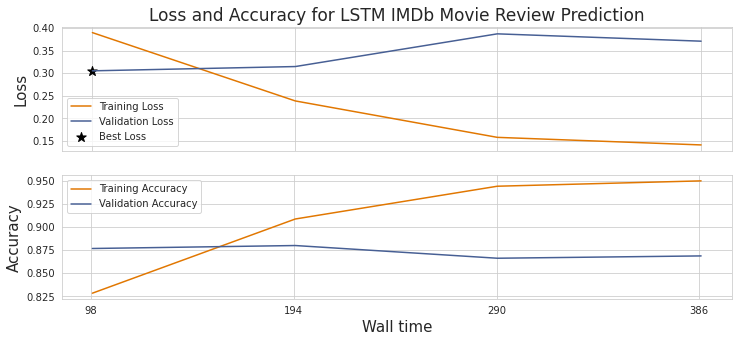

In [45]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 
                                   # 1 LSTM -> 1 Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# stacked LSTM -> 2 layers

# build and compile model
model_9 = get_compiled_lstm(n_units=2)
# train model
train_model(model_9, 'model_9')
# store training data in dict
data_9 = get_training_data(model_9)
# plot training data
plot_one_model(data_9, x_var='epoch')
plot_one_model(data_9, x_var='wall_time')

Training time has increased significantly over model 3 (1 layer).<br>
The performance has decreased, as well.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         3779712   
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)             

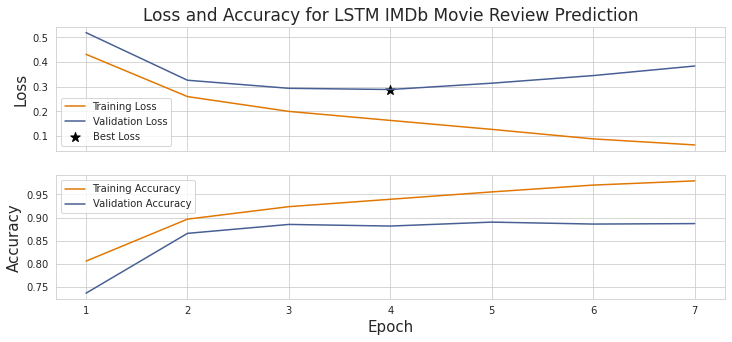

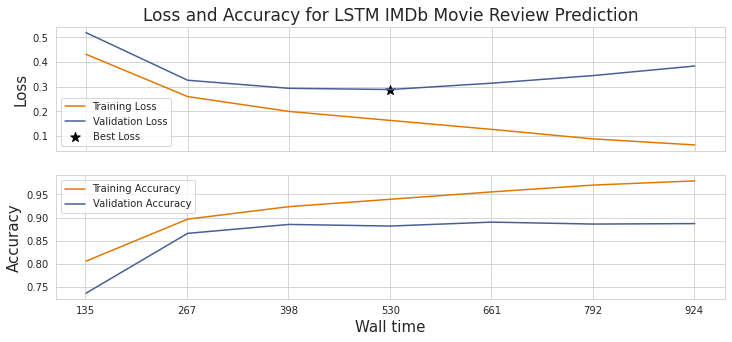

In [46]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 
                                   # 1 LSTM -> 1 Dropout -> 
                                   # 1 LSTM -> 1 Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# stacked LSTM -> 3 layers

# build and compile model
model_10 = get_compiled_lstm(n_units=3)
# train model
train_model(model_10, 'model_10')
# store training data in dict
data_10 = get_training_data(model_10)
# plot training data
plot_one_model(data_10, x_var='epoch')
plot_one_model(data_10, x_var='wall_time')

Training time has increased, even more.<br>
Similarly, the performance has decreased, also.

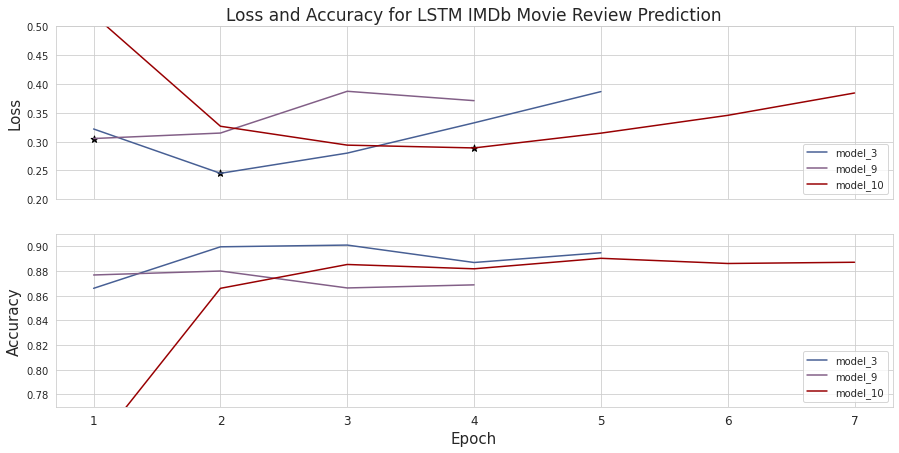

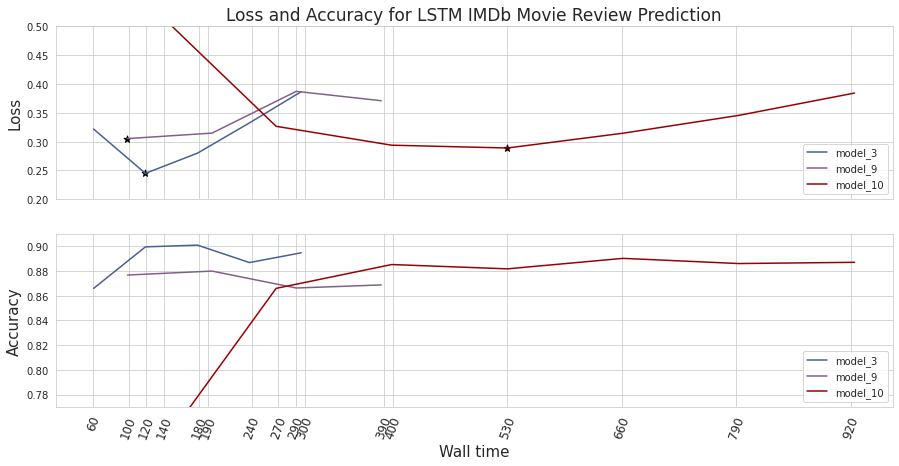

In [47]:
# collect all training data
df_lst = get_training_logs()
# create list of models to observe
training_lst = [df_lst[3], df_lst[9], df_lst[10]]
# plot chosen models
plot_training_data(training_lst, x_var='epoch')
plot_training_data(training_lst, x_var='wall_time')

No improvements are seen in either performance or training time, by adding layers to model 3.

 > **LAYER COMPLEXITY**

Now, I will add complexity to the models by doubling the number of nodes in each LSTM layer.<br>
Once again, stacked layers will be added, up to 3 layers deep.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 256)         7559424   
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 8,084,993
Trainable params: 8,084,993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 90s 72ms/step - loss: 0.5206 - accuracy: 0.7428 - val_loss: 0.4361 - val_accuracy: 0.8060 - wall_time: 91.6403
Epoch 2/20
1250/1250 [==============================] - 90s 72ms/step - lo

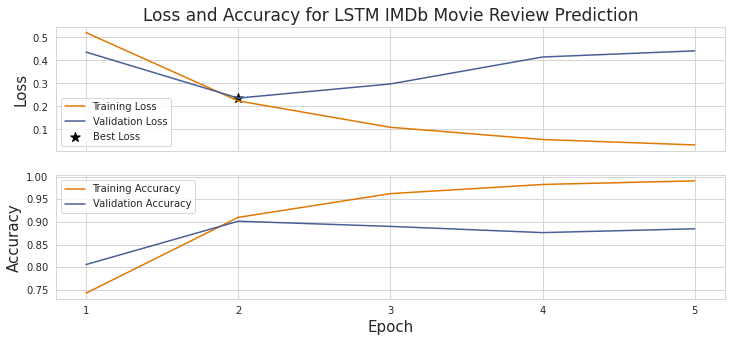

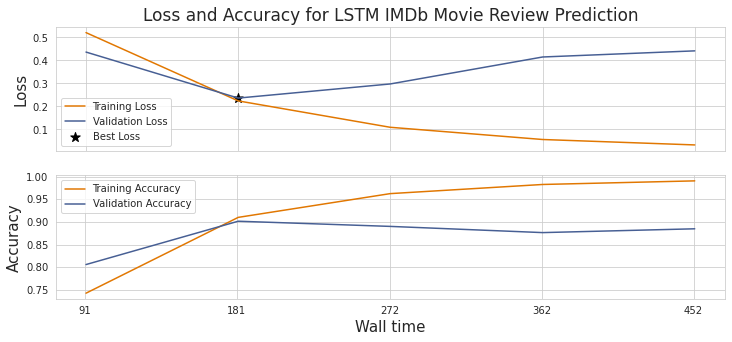

In [48]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# nodes per layer -> 256

# build and compile model
model_11 = get_compiled_lstm(n_nodes=256)
# train model
train_model(model_11, 'model_11')
# store training data in dict
data_11 = get_training_data(model_11)
# plot training data
plot_one_model(data_11, x_var='epoch')
plot_one_model(data_11, x_var='wall_time')

I will compare the two models with only one layer, but having a different number of nodes.

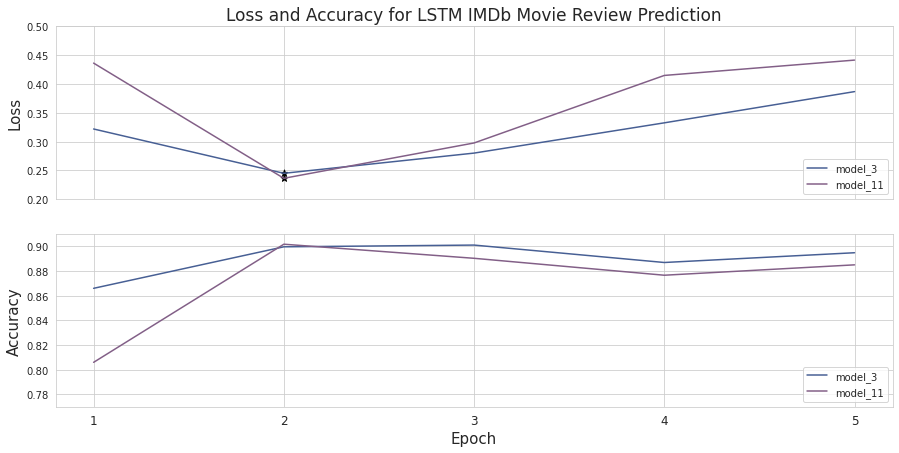

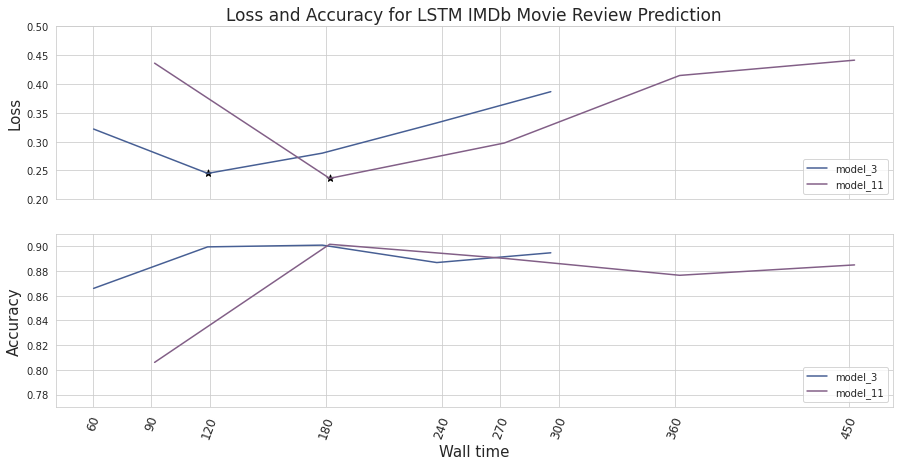

In [49]:
# collect all training data
df_lst = get_training_logs()
# create list of models to observe
training_lst = [df_lst[3], df_lst[11]]
# plot chosen models
plot_training_data(training_lst, x_var='epoch')
plot_training_data(training_lst, x_var='wall_time')

Model 11 (256 nodes) has a much slower training time than model 3 (156 nodes).<br>
On the plus side, adding more neurons has, finally, improved the performance.

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 256)         7559424   
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 256)         525312    
_________________________________________________________________
dropout_15 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 8,610,305
Trainable params: 8,610,305
Non-trainable params: 0
___________________________________________

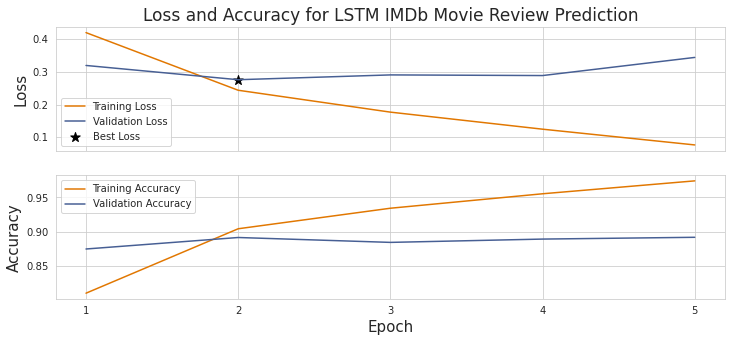

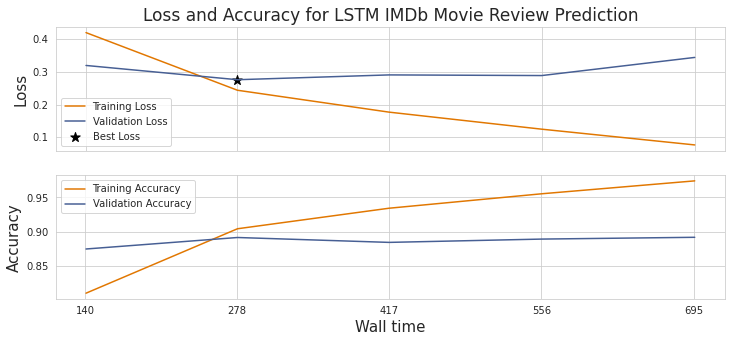

In [50]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 
                                   # 1 LSTM -> 1 Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# stacked LSTM -> 2 layers
# nodes per layer -> 256

# build and compile model
model_12 = get_compiled_lstm(n_units=2, n_nodes=256)
# train model
train_model(model_12, 'model_12')
# store training data in dict
data_12 = get_training_data(model_12)
# plot training data
plot_one_model(data_12, x_var='epoch')
plot_one_model(data_12, x_var='wall_time')

Now, I will compare the models with 2 stacked layers.

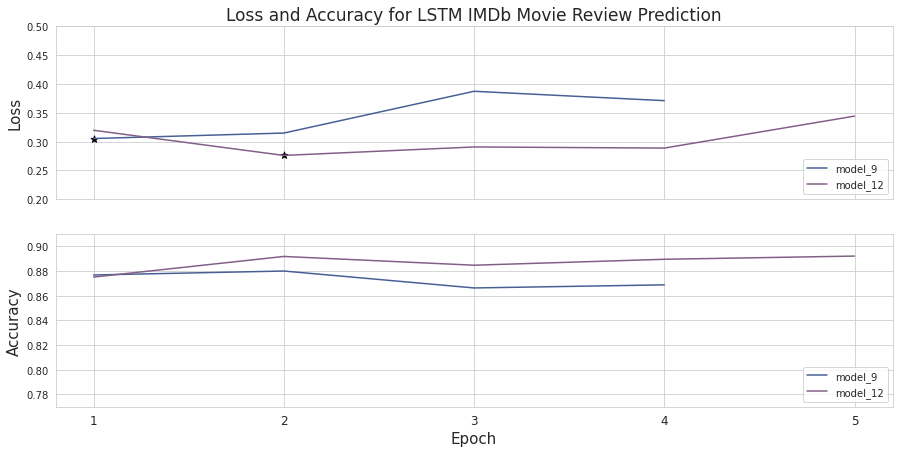

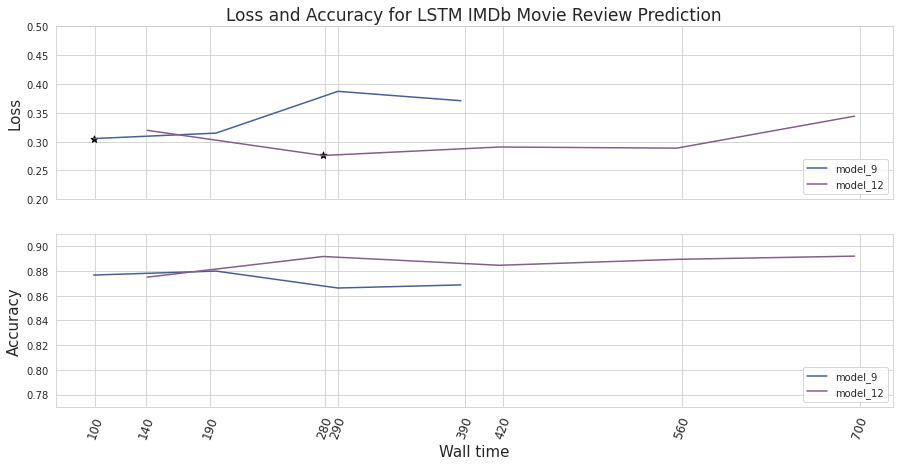

In [51]:
# collect all training data
df_lst = get_training_logs()
# create list of models to observe
training_lst = [df_lst[9], df_lst[12]]
# plot chosen models
plot_training_data(training_lst, x_var='epoch')
plot_training_data(training_lst, x_var='wall_time')

Adding more nodes to the deeper model has improved the performance at the cost of training time.

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 256)         7559424   
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 256)         525312    
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 256)         525312    
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)             

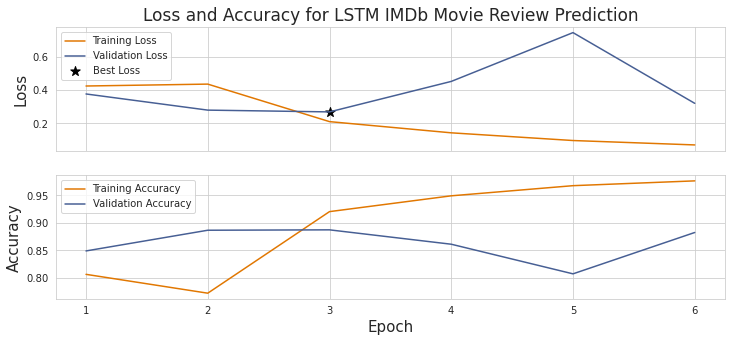

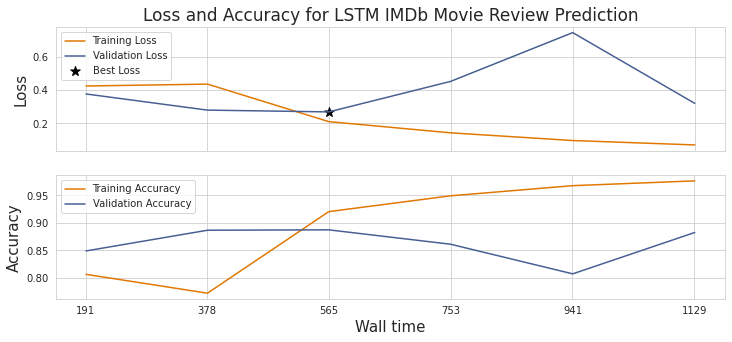

In [52]:
# model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 
                                   # 1 LSTM -> 1 Dropout -> 
                                   # 1 LSTM -> 1 Dropout -> 1 Dense layer
# corpus word limit -> 29,529 words
# review word limit -> 831 words
# stacked LSTM -> 3 layers
# nodes per layer -> 256

# build and compile model
model_13 = get_compiled_lstm(n_units=3, n_nodes=256)
# train model
train_model(model_13, 'model_13')
# store training data in dict
data_13 = get_training_data(model_13)
# plot training data
plot_one_model(data_13, x_var='epoch')
plot_one_model(data_13, x_var='wall_time')

Here, I will compare the models with 3 layers.

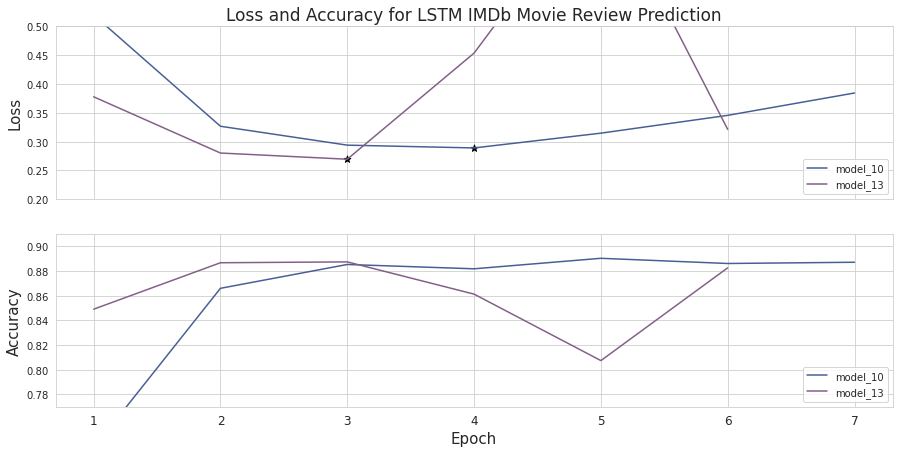

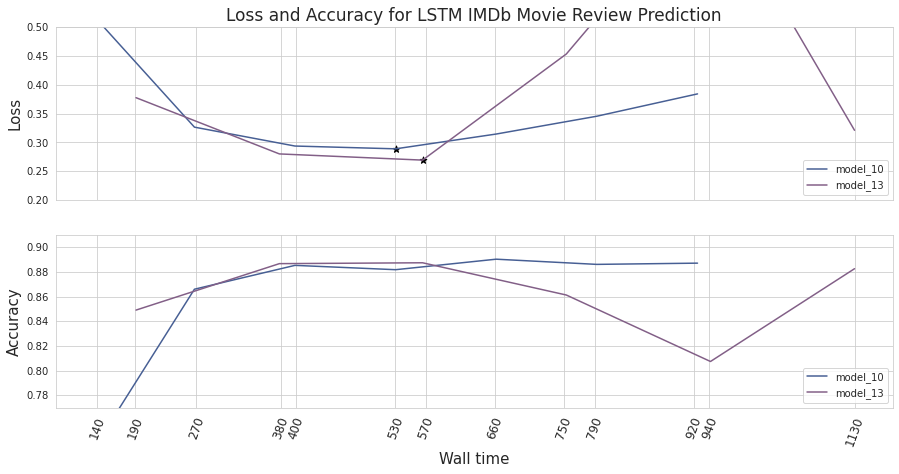

In [53]:
# collect all training data
df_lst = get_training_logs()
# create list of models to observe
training_lst = [df_lst[10], df_lst[13]]
# plot chosen models
plot_training_data(training_lst, x_var='epoch')
plot_training_data(training_lst, x_var='wall_time')

Training time has increased, with decrease in performance.

Now, I will plot all of the models with 256 nodes in each of their layers.

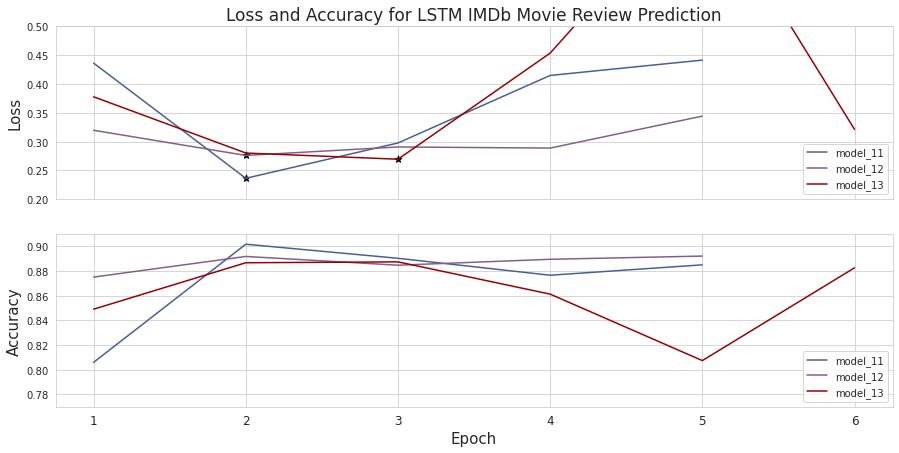

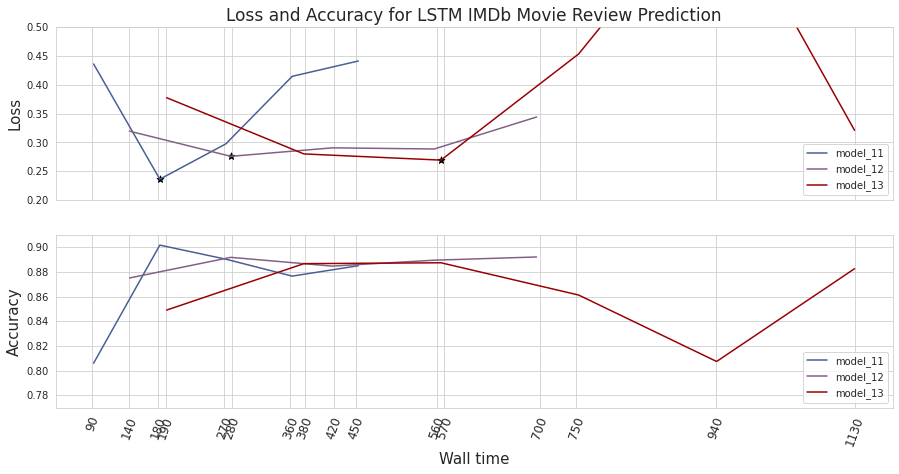

In [54]:
# collect all training data
df_lst = get_training_logs()
# create list of models to observe
training_lst = [df_lst[11], df_lst[12], df_lst[13]]
# plot chosen models
plot_training_data(training_lst, x_var='epoch')
plot_training_data(training_lst, x_var='wall_time')

Training time increases with additional layers.<br>
The model 11 (1 layer) performs the best.

Finally, I'll look back to compare the best two models.

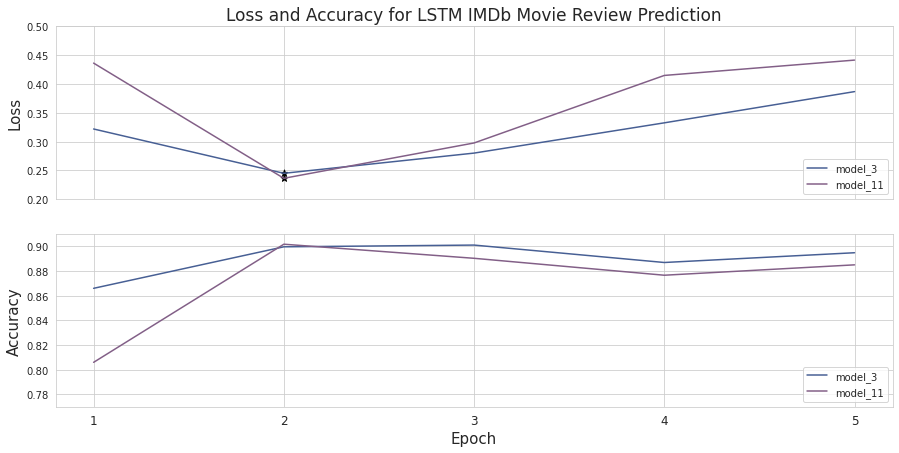

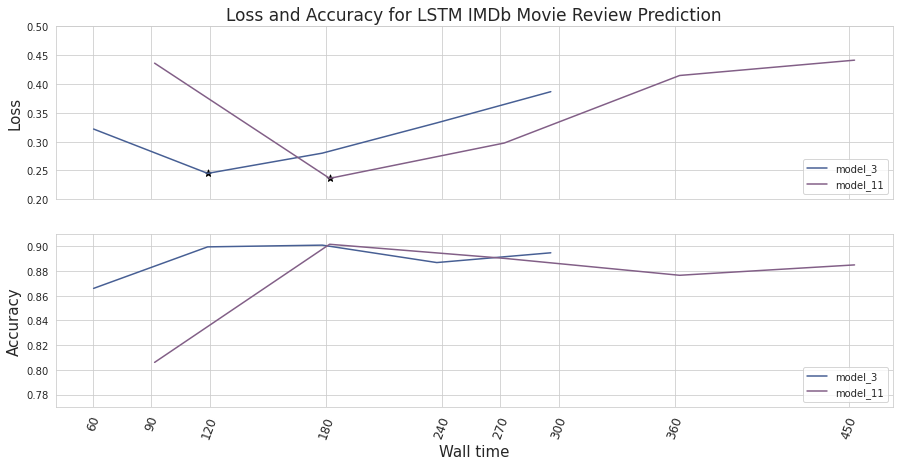

In [55]:
# collect all training data
df_lst = get_training_logs()
# create list of models to observe
training_lst = [df_lst[3], df_lst[11]]
# plot chosen models
plot_training_data(training_lst, x_var='epoch')
plot_training_data(training_lst, x_var='wall_time')

The difference between Models 3 and 11 is the number of neurons in each of their single LSTM layers.<br>
Their training curves look similar, when viewing them over epochs.<br>
Although Model 3 has a better training time, Model 11 still finishes each epoch in only one and a half minutes.<br>
This duration is well under the two minutes that I had wanted to achieve.<br>
Model 11 has superior performance on the validation data.<br>
Given these observations, model 11 should be the best to choose for sentiment prediction on this dataset.

MODEL 11:<br>
model architecture: 1 Embedding -> 1 LSTM -> 1 Dropout -> 1 Dense layer<br>
corpus word limit -> 29,529 words<br>
review word limit -> 831 words<br>
dropout -> None<br>
batch size -> 32<br>
learning rate -> 0.001<br>
stacked LSTM -> None (1 layer)<br>
nodes per layer -> 256